<a href="https://colab.research.google.com/github/eyalbd2/097215_Natural-Language-Processing_Workshop-Notebooks/blob/master/NLP_3_DNN_POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://img.icons8.com/dusk/64/000000/mind-map.png" style="height:50px;display:inline"> IE 097215 - Technion - Natural Language Processing

## Pytorch - Implementing a POS tagger
In the first assignment in the course you have implemented a POS-MEMM tagger. We have used manually handcrafted features to represent input text. In this workshop we will use a Deep Neural Network (DNN) to represent input text. This notebook includes specific modules which you can be use in the second assignment of the course.



####**Importing all necessery packages.** 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "/content/gdrive/My Drive/Colab Notebooks/data/POS/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from torch.utils.data.dataloader import DataLoader

####**Create Vocabulary**
We will first implement a util function and then we will extract vocabulary out of our data.

In [0]:
def split(string, delimiters):
    """
        Split strings according to delimiters
        :param string: full sentence
        :param delimiters string: characters for spliting
            function splits sentence to words
    """
    delimiters = tuple(delimiters)
    stack = [string, ]

    for delimiter in delimiters:
        for i, substring in enumerate(stack):
            substack = substring.split(delimiter)
            stack.pop(i)
            for j, _substring in enumerate(substack):
                stack.insert(i + j, _substring)

    return stack

In [0]:
def get_vocabs(list_of_paths):
    """
        Extract vocabs from given datasets. Return a word2ids and tag2idx.
        :param file_paths: a list with a full path for all corpuses
            Return:
              - word2idx
              - tag2idx
    """
    word_dict = defaultdict(int)
    pos_dict = defaultdict(int)
    for file_path in list_of_paths:
        with open(file_path) as f:
            for line in f:
                splited_words = split(line, (' ', '\n'))
                del splited_words[-1]
                for word_and_tag in splited_words:
                    word, pos_tag = split(word_and_tag, '_')
                    word_dict[word] += 1
                    pos_dict[pos_tag] += 1

    return word_dict, pos_dict
# ******************* USAGE EXAMPLE (this is good practice) *******************
# path_train = "data/train.wtag"
# path_test = "data/test.wtag"
# paths_list = [path_train, path_test]
# word_dict, pos_dict = get_vocabs(paths_list)
# *****************************************************************************

####**Data Reader**

In [0]:
from collections import defaultdict

class PosDataReader:
    def __init__(self, file, word_dict, pos_dict):
        self.file = file
        self.word_dict = word_dict
        self.pos_dict = pos_dict
        self.sentences = []
        self.__readData__()
    
    def __readData__(self):
        """main reader function which also populates the class data structures"""
        with open(self.file, 'r') as f:
          for line in f:
              cur_sentence = []
              splited_words = split(line, (' ', '\n'))
              del splited_words[-1]
              for word_and_tag in splited_words:
                  cur_word, cur_tag = split(word_and_tag, '_')
                  cur_sentence.append((cur_word, cur_tag))
              self.sentences.append(cur_sentence)

    def get_num_sentences(self):
        """returns num of sentences in data"""
        return len(self.sentences)


####**Dataset**

In [0]:
from torchtext.vocab import Vocab
from torch.utils.data.dataset import Dataset, TensorDataset
from pathlib import Path
from collections import Counter

# These are not relevant for our POS tagger but might be usefull for HW2
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>" # Optional: this is used to pad a batch of sentences in different lengths.
# ROOT_TOKEN = PAD_TOKEN # this can be used if you are not padding your batches
# ROOT_TOKEN = "<root>" # use this if you are padding your batches and want a special token for ROOT
SPECIAL_TOKENS = [PAD_TOKEN, UNKNOWN_TOKEN]


class PosDataset(Dataset):
    def __init__(self, word_dict, pos_dict, dir_path: str, subset: str, 
                 padding=False, word_embeddings=None):
        super().__init__()
        self.subset = subset # One of the following: [train, test]
        self.file = dir_path + subset + ".wtag"
        self.datareader = PosDataReader(self.file, word_dict, pos_dict)
        self.vocab_size = len(self.datareader.word_dict)
        if word_embeddings:
            self.word_idx_mappings, self.idx_word_mappings, self.word_vectors = word_embeddings
        else:
            self.word_idx_mappings, self.idx_word_mappings, self.word_vectors = self.init_word_embeddings(self.datareader.word_dict)
        self.pos_idx_mappings, self.idx_pos_mappings = self.init_pos_vocab(self.datareader.pos_dict)
        
        self.pad_idx = self.word_idx_mappings.get(PAD_TOKEN)
        self.unknown_idx = self.word_idx_mappings.get(UNKNOWN_TOKEN)
        self.word_vector_dim = self.word_vectors.size(-1)
        self.sentence_lens = [len(sentence) for sentence in self.datareader.sentences]
        self.max_seq_len = max(self.sentence_lens)
        self.sentences_dataset = self.convert_sentences_to_dataset(padding)

    def __len__(self):
        return len(self.sentences_dataset)

    def __getitem__(self, index):
        word_embed_idx, pos_embed_idx, sentence_len = self.sentences_dataset[index]
        return word_embed_idx, pos_embed_idx, sentence_len

    @staticmethod
    def init_word_embeddings(word_dict):
        glove = Vocab(Counter(word_dict), vectors="glove.6B.300d", specials=SPECIAL_TOKENS)
        return glove.stoi, glove.itos, glove.vectors

    def get_word_embeddings(self):
        return self.word_idx_mappings, self.idx_word_mappings, self.word_vectors

    def init_pos_vocab(self, pos_dict):
        idx_pos_mappings = sorted([self.word_idx_mappings.get(token) for token in SPECIAL_TOKENS])
        pos_idx_mappings = {self.idx_word_mappings[idx]: idx for idx in idx_pos_mappings}
        
        for i, pos in enumerate(sorted(pos_dict.keys())):
            # pos_idx_mappings[str(pos)] = int(i)
            pos_idx_mappings[str(pos)] = int(i+len(SPECIAL_TOKENS))
            idx_pos_mappings.append(str(pos))
        print("idx_pos_mappings -", idx_pos_mappings)
        print("pos_idx_mappings -", pos_idx_mappings)
        return pos_idx_mappings, idx_pos_mappings
        
    def get_pos_vocab(self):
        return self.pos_idx_mappings, self.idx_pos_mappings

    def convert_sentences_to_dataset(self, padding):
        sentence_word_idx_list = list()
        sentence_pos_idx_list = list()
        sentence_len_list = list()
        for sentence_idx, sentence in enumerate(self.datareader.sentences):
            words_idx_list = []
            pos_idx_list = []
            for word, pos in sentence:
                words_idx_list.append(self.word_idx_mappings.get(word))
                pos_idx_list.append(self.pos_idx_mappings.get(pos))
            sentence_len = len(words_idx_list)
            # if padding:
            #     while len(words_idx_list) < self.max_seq_len:
            #         words_idx_list.append(self.word_idx_mappings.get(PAD_TOKEN))
            #         pos_idx_list.append(self.pos_idx_mappings.get(PAD_TOKEN))
            sentence_word_idx_list.append(torch.tensor(words_idx_list, dtype=torch.long, requires_grad=False))
            sentence_pos_idx_list.append(torch.tensor(pos_idx_list, dtype=torch.long, requires_grad=False))
            sentence_len_list.append(sentence_len)
        
        # if padding:
        #     all_sentence_word_idx = torch.tensor(sentence_word_idx_list, dtype=torch.long)
        #     all_sentence_pos_idx = torch.tensor(sentence_pos_idx_list, dtype=torch.long)
        #     all_sentence_len = torch.tensor(sentence_len_list, dtype=torch.long, requires_grad=False)
        #     return TensorDataset(all_sentence_word_idx, all_sentence_pos_idx, all_sentence_len)
            
        return {i: sample_tuple for i, sample_tuple in enumerate(zip(sentence_word_idx_list,
                                                                     sentence_pos_idx_list,
                                                                     sentence_len_list))}

In [0]:
path_train = data_dir + "train.wtag"
print("path_train -", path_train)
path_test = data_dir + "test.wtag"
print("path_test -", path_test)

paths_list = [path_train, path_test]
word_dict, pos_dict = get_vocabs(paths_list)
train = PosDataset(word_dict, pos_dict, data_dir, 'train', padding=False)
train_dataloader = DataLoader(train, shuffle=True)
test = PosDataset(word_dict, pos_dict, data_dir, 'test', padding=False)
test_dataloader = DataLoader(test, shuffle=False)




path_train - /content/gdrive/My Drive/Colab Notebooks/data/POS/train.wtag
path_test - /content/gdrive/My Drive/Colab Notebooks/data/POS/test.wtag


.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 398971/400000 [00:37<00:00, 10812.02it/s]

idx_pos_mappings - [0, 1, '#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
pos_idx_mappings - {'<pad>': 0, '<unk>': 1, '#': 2, '$': 3, "''": 4, ',': 5, '-LRB-': 6, '-RRB-': 7, '.': 8, ':': 9, 'CC': 10, 'CD': 11, 'DT': 12, 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'MD': 19, 'NN': 20, 'NNP': 21, 'NNPS': 22, 'NNS': 23, 'PDT': 24, 'POS': 25, 'PRP': 26, 'PRP$': 27, 'RB': 28, 'RBR': 29, 'RBS': 30, 'RP': 31, 'SYM': 32, 'TO': 33, 'UH': 34, 'VB': 35, 'VBD': 36, 'VBG': 37, 'VBN': 38, 'VBP': 39, 'VBZ': 40, 'WDT': 41, 'WP': 42, 'WP$': 43, 'WRB': 44, '``': 45}
idx_pos_mappings - [0, 1, '#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'P

In [0]:
print("Number of Train Tagged Sentences ", len(train))
print("Number of Test Tagged Sentences ",len(test))


Number of Train Tagged Sentences  5000
Number of Test Tagged Sentences  1000


####**Create a model**

We will implement an LSTM model and a Viterbi based LSTM model.

In [0]:
class DnnPosTagger(nn.Module):
    def __init__(self, word_embeddings, hidden_dim, word_vocab_size, tag_vocab_size):
        super(DnnPosTagger, self).__init__()
        emb_dim = word_embeddings.shape[1]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        self.word_embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=2, bidirectional=True, batch_first=False)
        self.hidden2tag = nn.Linear(hidden_dim*2, tag_vocab_size)

        
    def forward(self, word_idx_tensor):
        embeds = self.word_embedding(word_idx_tensor.to(self.device))   # [batch_size, seq_length, emb_dim]      
        lstm_out, _ = self.lstm(embeds.view(embeds.shape[1], 1, -1))    # [seq_length, batch_size, 2*hidden_dim]
        tag_space = self.hidden2tag(lstm_out.view(embeds.shape[1], -1)) # [seq_length, tag_dim]
        tag_scores = F.log_softmax(tag_space, dim=1)                    # [seq_length, tag_dim]
        return tag_scores

####**Evaluation Method**

In [0]:
def evaluate():
    acc = 0
    with torch.no_grad():
        for batch_idx, input_data in enumerate(test_dataloader):
            
            words_idx_tensor, pos_idx_tensor, sentence_length = input_data  
            tag_scores = model(words_idx_tensor)
            tag_scores = tag_scores.unsqueeze(0).permute(0,2,1)
            
            _, indices = torch.max(tag_scores, 1)
            acc += torch.mean(torch.tensor(pos_idx_tensor.to("cpu") == indices.to("cpu"), dtype=torch.float))
        acc = acc / len(test)
    return acc

####**Training The LSTM Model**

In [0]:
#CUDA_LAUNCH_BLOCKING=1  

EPOCHS = 15
WORD_EMBEDDING_DIM = 100
HIDDEN_DIM = 1000
word_vocab_size = len(train.word_idx_mappings)
tag_vocab_size = len(train.pos_idx_mappings)

model = DnnPosTagger(train_dataloader.dataset.word_vectors, HIDDEN_DIM, word_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer to minimize the loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
acumulate_grad_steps = 50 # This is the actual batch_size, while we officially use batch_size=1

# Training start
print("Training Started")
accuracy_list = []
loss_list = []
epochs = EPOCHS
for epoch in range(epochs):
    acc = 0 # to keep track of accuracy
    printable_loss = 0 # To keep track of the loss value
    i = 0
    for batch_idx, input_data in enumerate(train_dataloader):
        i += 1
        words_idx_tensor, pos_idx_tensor, sentence_length = input_data
        
        tag_scores = model(words_idx_tensor)
        tag_scores = tag_scores.unsqueeze(0).permute(0,2,1)
        #print("tag_scores shape -", tag_scores.shape)
        #print("pos_idx_tensor shape -", pos_idx_tensor.shape)
        loss = loss_function(tag_scores, pos_idx_tensor.to(device))
        loss = loss / acumulate_grad_steps
        loss.backward()

        if i % acumulate_grad_steps == 0:
            optimizer.step()
            model.zero_grad()
        printable_loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
        # print("tag_scores shape-", tag_scores.shape)
        # print("indices shape-", indices.shape)
        # acc += indices.eq(pos_idx_tensor.view_as(indices)).mean().item()
        acc += torch.mean(torch.tensor(pos_idx_tensor.to("cpu") == indices.to("cpu"), dtype=torch.float))
    printable_loss = printable_loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(printable_loss))
    accuracy_list.append(float(acc))
    test_acc = evaluate()
    e_interval = i
    print("Epoch {} Completed,\tLoss {}\tAccuracy: {}\t Test Accuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]), test_acc))
        

100%|█████████▉| 398971/400000 [00:50<00:00, 10812.02it/s]

Training Started


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1 Completed,	Loss 0.05435596079258248	Accuracy: 0.2656257152557373	 Test Accuracy: 0.47855710983276367
Epoch 2 Completed,	Loss 0.03576184127254528	Accuracy: 0.5208622813224792	 Test Accuracy: 0.8844269514083862
Epoch 3 Completed,	Loss 0.02586716541693507	Accuracy: 0.6554659008979797	 Test Accuracy: 0.9045175313949585
Epoch 4 Completed,	Loss 0.020271231177345545	Accuracy: 0.7303514033555984	 Test Accuracy: 0.9106523990631104
Epoch 5 Completed,	Loss 0.016707569406348776	Accuracy: 0.7776372790336609	 Test Accuracy: 0.9197829961776733
Epoch 6 Completed,	Loss 0.014239116449190079	Accuracy: 0.8102470139662424	 Test Accuracy: 0.9223999381065369
Epoch 7 Completed,	Loss 0.012422604812690198	Accuracy: 0.8341747266905648	 Test Accuracy: 0.9255969524383545
Epoch 8 Completed,	Loss 0.011037156624331464	Accuracy: 0.8523860424757004	 Test Accuracy: 0.9201141595840454
Epoch 9 Completed,	Loss 0.00994286882162011	Accuracy: 0.8667581743664212	 Test Accuracy: 0.9254709482192993
Epoch 10 Completed,	Lo

####**Plot Training Results**

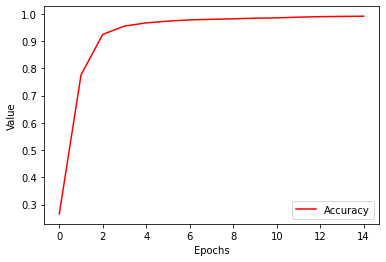

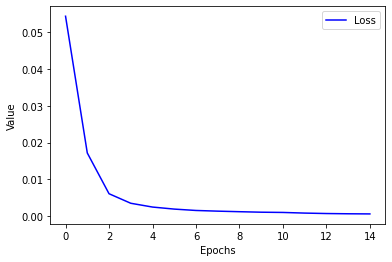

In [0]:
import matplotlib.pyplot as plt

plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

####**How To Implement HW2 Dependency Parser**

In HW2 we will implement the Graph-based Dependency Parser presented by Kiperwasser and Goldberg. In their [paper](https://https://arxiv.org/pdf/1603.04351.pdf), Kiperwasser and Goldberg proposed a Bidirectional LSTM model to extract features from the words and POS tags of a sentence, and generate an adjacency matrix representing the dependency edge scores between every two nodes (words) in the sentence. This matrix is then used by the Chu-Liu-Edmonds algorithm to create a valid parse tree.\
For further details, please read sections 3 (Our Approach), 5 (Graph-based Parser),  Implementation details and Hyperparameter tuning under section 6 (Experiments and Results) from the [paper](https://arxiv.org/pdf/1603.04351.pdf).\
**Please note:** instead of using the max-margin loss function presented in section 5 of the paper, we shall minimize the negative log-likelihood loss function ($NLLLoss$) which you will implement in your code:
$$\min_{\theta} NLLLoss(D;\theta) = \\ \min_{\theta}\sum_{(X^i,Y^i) \in D} \sum_{(h,m) \in Y^i} -\frac{1}{|Y^i|} \cdot log(P(S^i_{h,m}|X^i,\theta))$$
$$P(S^i_{h,m}|X^i,\theta)=\frac{exp(S^i_{h,m})}{\sum_{j=1}^{|Y^i|} exp(S^i_{j,m})}=Softmax(S^i_{h,m})$$
Where:

* $ D = \{(X^i,Y^i)\}_{i=1}^n $, Dataset consisting of $n$ (sentence, true tree) pairs. 
* $X^i = \{x_0=ROOT,x_1,...,x_{k_i}\}$ is the full sequence of words in the sentence.
* $Y^i=\{(h,m)\}$ is the set of all (head_index, modifier_index) edges in the **true** dependency tree of sentence $X^i$. $|Y^i|=k_i$.
* $S^i \in R^{(k_i+1)^2}$ is the score matrix for all possible (head, modifier) edges in the dependency graph of sentence $X^i$.
The cell $S^i_{h,m}$ refers to the score of $h$ being the head of $m$ in sentence $X^i$.
* $\theta$ are the network's learned parameters

Below we give a basic structure for the network's code implementation.


In [0]:
from chu_liu_edmonds import decode_mst


class KiperwasserDependencyParser(nn.Module):
    def __init__(self, *args):
      super(KiperwasserDependencyParser, self).__init__()
      self.word_embedding = # Implement embedding layer for words (can be new or pretrained - word2vec/glove)
      self.pos_embedding = # Implement embedding layer for POS tags
      self.hidden_dim = self.word_embedding.embedding_dim + self.pos_embedding.embedding_dim
      self.encoder = # Implement BiLSTM module which is fed with word+pos embeddings and outputs hidden representations
      self.edge_scorer = # Implement a sub-module to calculate the scores for all possible edges in sentence dependency graph
      self.decoder = decode_mst # This is used to produce the maximum spannning tree during inference
      self.loss_function = # Implement the loss function described above

    def forward(self, sentence):
      word_idx_tensor, pos_idx_tensor, true_tree_heads = sentence

      # Pass word_idx and pos_idx through their embedding layers

      # Concat both embedding outputs

      # Get Bi-LSTM hidden representation for each word+pos in sentence

      # Get score for each possible edge in the parsing graph, construct score matrix     
        
      # Use Chu-Liu-Edmonds to get the predicted parse tree T' given the calculated score matrix

      # Calculate the negative log likelihood loss described above
      
      return loss, predicted_tree

SyntaxError: ignored

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Much of the code above is adjusted from  <a href="https://www.kaggle.com/krishanudb/lstm-character-word-pos-tag-model-pytorch/data">this Kaggle tutorial</a>
* By <a href="https://github.com/eyalbd2">Eyal Ben David</a> and <a href="https://github.com/nadavo">Nadav Oved </a>